# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [4]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

In [5]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

thtc_docs = text_splitter.split_documents(docs)

In [6]:
len(thtc_docs)

208

In [7]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=thtc_docs,
    embedding=embedding_model,
    location=":memory:"
)

In [8]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

In [9]:
from langchain_core.tools import tool
from typing import Annotated, List, Tuple, Union
@tool
def retrieve(
    query: Annotated[str, "query about information in the tight hips, twisted core book"]
    ):
  """provides detailed information about the book "Tight Hip, Twisted Core" by Christine Koth, which focuses on understanding, diagnosing, treating, and preventing issues related to tight hip flexors, particularly the iliacus muscle, and their widespread impact on the body. It can help agents answer queries about the causes and effects of iliopsoas tightness throughout the body, as well as solutions for relief and prevention, including self-treatment and professional interventions"""
  retrieved_docs = qdrant_retriever.invoke(query)
  return {"context" : retrieved_docs}


In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

from langchain_core.tools import Tool

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
    Tool.from_function(
        func=retrieve,
        name="Retrieve",
        description="provides detailed information about the book `Tight Hip, Twisted Core` by Christine Koth, which focuses on understanding, diagnosing, treating, and preventing issues related to tight hip flexors, particularly the iliacus muscle, and their widespread impact on the body. It can help agents answer queries about the causes and effects of iliopsoas tightness throughout the body, as well as solutions for relief and prevention, including self-treatment and professional interventions")
]

/var/folders/r5/wsbp5_jj7lsfh6rxrw7p7lv00000gn/T/ipykernel_46537/76110118.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [11]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [12]:
model = model.bind_tools(tool_belt)

Tells model how it can call the functions. provides a json describing each tool.

#### ❓ Question #1:

How does the model determine which tool to use?

#### ✅ ANSWER
When we bind tools to the model, it establishes a metadata field called TOOLS that looks like this:

```
tools: [
    {
    "type": "function",
    "function": {
        "name": "tavily_search_results_json",
        "description": "A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.",
        "parameters": {
        "properties": {
            "query": {
            "description": "search query to look up",
            "type": "string"
            }
        },
        "required": [
            "query"
        ],
        "type": "object"
        }
    }
    }, {
    "type": "function",
    "function": {
        "name": "arxiv",
        "description": "A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.",
        "parameters": {
        "properties": {
            "query": {
            "description": "search query to look up",
            "type": "string"
            }
        },
        "required": [
            "query"
        ],
        "type": "object"
        }
    }
    }
}
```

The model reads the description of each tool to determine which one works best for the task it is trying to complete.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [13]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

# use context from previous parts of agent to achieve it's task
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [14]:
def planner_node(state):
    query = state["messages"][-1].content
    plan = model.invoke(f"Break down the question into research steps: {query}")
    return {"messages": [plan]}


In [15]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

# we call the tool with the payload provided by the model
tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [16]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

# uncompiled_graph.add_node("planner", planner_node)
uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [ ]:
uncompiled_graph.set_entry_point("agent")
# uncompiled_graph.add_edge("planner", "agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [18]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [19]:

uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [20]:
simple_agent_graph = uncompiled_graph.compile()

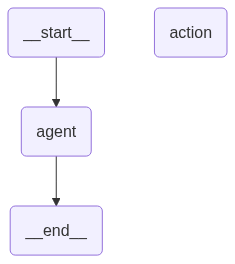

In [21]:
simple_agent_graph

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

### ✅ ANSWER

**Is there a specific limit?**
- No, LangGraph does not impose a default limit on cycles
- Infinite loops are possible and can cause memory/resource exhaustion

**How to implement limits:**

1. **Message count limit** (as shown in our code):
   ```python
   if len(state["messages"]) > 10:
       return "END"
   ```

2. **Recursion limit at compile time**:
   ```python
   graph.compile(recursion_limit=20)
   ```

3. **Custom state counter**:
   ```python
   class AgentState(TypedDict):
       messages: Annotated[list, add_messages]
       cycle_count: int
   ```

4. **Implementation locations**:
   - Conditional edges (as shown in our example)
   - Individual nodes
   - At graph compilation time

The notebook demonstrates the message count approach, which is simple and effective for most use cases.

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [25]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="how does the iliacus muscle affect the body and what are some research papers on it? Design a workout plan to help with the iliacus muscle")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lno0YSC6FmL0R428rbPc7SSI', 'function': {'arguments': '{"query": "iliacus muscle function and impact on the body"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_I5vQ8JfiFSrIhweUFrn5qkiV', 'function': {'arguments': '{"query": "workout plan for iliacus muscle"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 292, 'total_tokens': 350, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BuNdjwp12vFfsXKzBBKDlHeGZDiDT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3d23d445-3c01-48e3-88f4-72cd5b1a9f2c-0', tool_calls=[{'

In [ ]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [ ]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [ ]:
def print_agent_values(values):
    for key, item in values.items():
            if key =="messages":
                print("Messages:")
                for msg in item:
                    print(f"  Type: {type(msg).__name__}")
                    if hasattr(msg, "content"):
                        print(f"  Content: {msg.content}")
                    if hasattr(msg, "function_call"):
                        print(f"  Function Call: {msg.function_call}")
            else:
                print(f"{key}: {item}")

In [ ]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print_agent_values(values)

        print("\n\n")

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

First, I don't think the answer is correct. It identifies the authors a but does not show their latest tweets. It shows a summary of some tweets but it is not clear that they are from the authors.
I used LangSmith to understand the steps taken

Steps:
1. Visit the `agent` node and provide the query to the LLM. The LLM requests:
    - tool call to arxiv to retrieve research papers related to QLora
    - 3 tool calls to tavily to fetch the latest tweets for each author
2. Visit the `should_continue` edge. Because the last message includes tool calls it returns "action"
3. Visit the `action` node
    - 1 call to arxiv which retreives a paper on QLoRa. The contents of the paper include the authors
    - 3 calls to tavily which retrieve some tweets in addition to some medium articles, github posts and other web content
        - None specifically include tweets from the authors
5. Visit the agent, with the results of the tool call in context
    - Make an LLM request but now with the tool call info in the context window
    - returns an answer
6. Visit the `should_continue` edge. The LLM decides the answer is accurate so "action" is returned


# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [ ]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [ ]:
agent_chain_with_formatting.invoke({"question" : "What is RAG?"})

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [ ]:
questions = [
    "What are the key components of a LangGraph system?",
    "How does LangGraph differ from a regular LangChain agent?",
    "What is the purpose of the StateGraph class in LangGraph?",
    "How do you handle branching logic in LangGraph?",
    "What are the benefits of using LangGraph over traditional agents?",
]

answers = [
    {"must_mention": ["nodes", "edges", "state"]},
    {"must_mention": ["graph", "workflow", "state management"]}, 
    {"must_mention": ["state", "transitions", "graph"]},
    {"must_mention": ["conditional", "routing", "edges"]},
    {"must_mention": ["complex workflows", "state tracking", "debugging"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [ ]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

### ✅ ANSWER

An answer is considered correct if it contains all of the keywords mentioned in the `must_mention` field.

**Why this approach is problematic**
This evaluation method has significant limitations:
1. Keyword presence ≠ Correctness: Simply including required keywords doesn't guarantee the answer is factually accurate or logically sound.
2. Hallucination risk: The LLM could generate responses that contain all the required keywords but provide completely incorrect explanations or context around them.
3. Incomplete evaluation: This approach only validates partial content rather than overall response quality, meaning it misses:
- Logical consistency
- Factual accuracy
- Proper context and explanation



### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [ ]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

❓ Question #4:
What are some ways you could improve this metric as-is?

NOTE: Alternatively you can suggest where gaps exist in this method.

### ✅ ANSWER
Recommended improvements:
To create a more robust evaluation system, consider implementing:
- Semantic evaluation: Use LLM-based evaluators to assess the overall correctness of explanations, not just keyword presence
- Reference answer comparison: Provide gold standard answers for more comprehensive evaluation
- Multi-criteria assessment: Combine keyword checking with accuracy, relevance, and completeness metrics
- Context-aware evaluation: Ensure keywords are used correctly within proper explanations


Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [ ]:
experiment_results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"Search Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

In [ ]:
experiment_results

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [ ]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### CREATING A NEW GRAPH AND ADDING AGENT AND ACTION NODE

In [ ]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### MAKE THE AGENT NODE THE FIRST NODE IN THE GRAPH

In [ ]:
graph_with_helpfulness_check.set_entry_point("agent")

##### CREATING A CONDITIONAL NODE TO DETERMINE WHETHER TO CONTINUE OR END

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

### ✅ ANSWER

1. Check the last emitted message. If it contains a tool call this indicates that the LLM is requesting some tool action so return "action"
2. If there is no request for a tool call, we check to see how many message have accumulated in our agent. If it exceeds 10, we return "END" indicating that we should stop the agent reasoning loop
3. If not we create a chain and use it to ask the LLM if the latest response is helpful in answering the users query
4. If the LLM deems it helpful, return "END" indicating that the angent should end and return the current response
5. If the LLM deems it unhelpful, return "CONTINUE" indicating that the reasoning loop should continue


##### ADD CONDITIONAL EDGE AFTER THE AGENT SPECIFYING WHAT NODE EACH OUTPUT MAPS TO

In [ ]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### ADDING AN EDGE FROM THE ACTION BACK TO THE AGENT

In [ ]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### COMPILING THE GRAPH SO IT CAN BE RAN

In [ ]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

##### EXECUTING THE GRAPH AND PRINTING UPDATES AT EACH NODE

In [ ]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [ ]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [ ]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")